In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from getS50 import *
from draw_compare_multiply import draw_compare_multiply
from sklearn.preprocessing import PowerTransformer
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

In [2]:
precision = dict()

In [3]:
def twoPointAngle(theta1, theta2, phi1, phi2):
    return np.rad2deg(
        np.arccos(
            np.sin(np.deg2rad(theta1))
            * np.sin(np.deg2rad(theta2))
            * np.cos(np.deg2rad(phi1 - phi2))
            + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
        )
    )


Energy_bin = np.logspace(0, 5, 26)
Energy_bin_center = 10**((np.log10(Energy_bin[:-1]) +
                         np.log10(Energy_bin[1:]))/2)
Energy_min = Energy_bin[:-1]
Energy_max = Energy_bin[1:]
bins_1 = np.linspace(-2, 2, 41)

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def check_fit(energy_pred, energy_orgin, title, savepath):
    plt.tight_layout()
    _, axes = plt.subplots(5, 5, sharey=True, figsize=(18, 18))
    precision_ = list()
    axes = axes.reshape(-1)
    for i in range(len(Energy_bin)-1):
        need = np.where((Energy_min[i] < energy_pred)
                        & (Energy_max[i] > energy_pred))
        need_draw = np.log(energy_pred[need]/energy_orgin[need])
        precision_.append(np.sqrt(np.mean(need_draw**2)))
        if need_draw.size != 0:
            axes[i].hist(need_draw, bins=bins_1, density=True)
            axes[i].set_title(
                f"{Energy_min[i]:.2f}<E_pred<{Energy_max[i]:.2f}", fontsize=10)
            axes[i].set_ylim(0, 4)
            axes[i].text(-2, 3,
                         f"error={np.sqrt(np.mean(need_draw**2)):.2f}\nstd={np.std(need_draw):.2f}\nmean={np.mean(need_draw):.2f}\n")
    plt.xlabel("ln(pred/true)")
    mkdir(savepath)
    plt.savefig(os.path.join(savepath, "resolution.png"))
    plt.show()
    plt.close()
    hist_orgin, _ = np.histogram(
        np.log10(energy_orgin), bins=np.log10(Energy_bin))
    hist_recon, _ = np.histogram(
        np.log10(energy_pred), bins=np.log10(Energy_bin))

    plt.errorbar(
        np.log10(Energy_bin_center),
        hist_orgin,
        np.sqrt(hist_orgin),
        np.ones(len(Energy_bin_center)) * 0.1,
        fmt=".",
        label="true Energy"
    )
    plt.errorbar(
        np.log10(Energy_bin_center),
        hist_recon,
        np.sqrt(hist_recon),
        np.ones(len(Energy_bin_center)) * 0.1,
        fmt=".",
        label="pred Energy"
    )
    plt.title(title)
    plt.axvline(x=1.2, color='r', linestyle='--')
    plt.axvline(x=2.2, color='r', linestyle='--')
    plt.xlabel("log10energy")
    plt.ylabel("dN")
    plt.legend()
    plt.yscale("log")
    plt.savefig(os.path.join(savepath, "compare_bin.png"))
    plt.show()
    plt.close()


    plt.scatter(np.log10(energy_pred), np.log10(energy_orgin), s=1)
    plt.plot([0, 5], [0, 5], c="r")
    plt.xlim(-1,5)
    plt.ylim(-1,5)
    plt.xlabel("energy_pred")
    plt.ylabel("energy_orgin")
    plt.savefig(os.path.join(savepath, "compare.png"))
    plt.show()
    precision[title] = precision_
    plt.close()
    for i in range(len(Energy_bin)-1):
        print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])

def draw_precision():
    for key in precision.keys():
        plt.plot(Energy_bin_center,
                 precision[key], "o:", label=key)
    plt.legend()
    plt.xlabel("Energy(TeV)")
    plt.ylabel("energy resolution")
    plt.xscale("log")
    plt.yscale("log")
    # plt.ylim(0.1, 0.6)
    # plt.xlim(10, 1e4)
    plt.savefig("./precision.png")
    plt.show()

In [4]:
file_J1857 = uproot.open("/home2/hky/github/Gamma_Energy/AllSky/forJ1857/RESULT_J1857.root")
data_J1857 = file_J1857["asresult"].arrays(["nch", "theta", "phi", "sigma", "cx", "cy", "sumpf",
                               "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie", "inout"], library="np")
data_J1857["cr"] = np.sqrt(data_J1857["cx"]**2+data_J1857["cy"]**2)
data_J1857["log10Energy"] = np.log10(data_J1857["prie"]/1000)
data_J1857["pritheta"] = np.rad2deg(data_J1857["pritheta"])
data_J1857["priphi"] = 180-np.rad2deg(data_J1857["priphi"])
data_J1857["priphi"][data_J1857["priphi"] > 180] = data_J1857["priphi"][data_J1857["priphi"] > 180]-360
data_J1857["S50"] = getS50(data_J1857["ne"], data_J1857["age"])
data_J1857["deltatheta"] = data_J1857["theta"]-data_J1857["pritheta"]
data_J1857["deltaphi"] = data_J1857["phi"]-data_J1857["priphi"]
data_J1857["deltaphi"][data_J1857["deltaphi"] <-180]+=360
data_J1857["deltaphi"][data_J1857["deltaphi"] >180]-=360

In [5]:
cuted_J1857 = np.where((data_J1857["theta"] < 50) & (data_J1857["nch"] >= 16)
                 & (data_J1857["inout"] == 1) & (data_J1857['sigma'] < 1.)
                 & (data_J1857["age"] > 0.31) & (data_J1857['age'] < 1.3)
                 & (data_J1857["S50"] > 10**-1.2)
                 & (data_J1857['sumpf'] > 200)
                 & ((data_J1857["summd"] < 1.8e-5*data_J1857["sumpf"]**1.8) | (data_J1857["summd"] < 0.4)))

In [6]:
data_test_J1857 = {key:data_J1857[key][cuted_J1857] for key in data_J1857.keys()}

In [7]:
pd_data_J1857 = pd.DataFrame(data_test_J1857)
pd_data_J1857[["ne","sumpf"]]=np.log10(pd_data_J1857[["ne","sumpf"]])


In [8]:
J1857_autogluon = TabularDataset(pd_data_J1857)

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

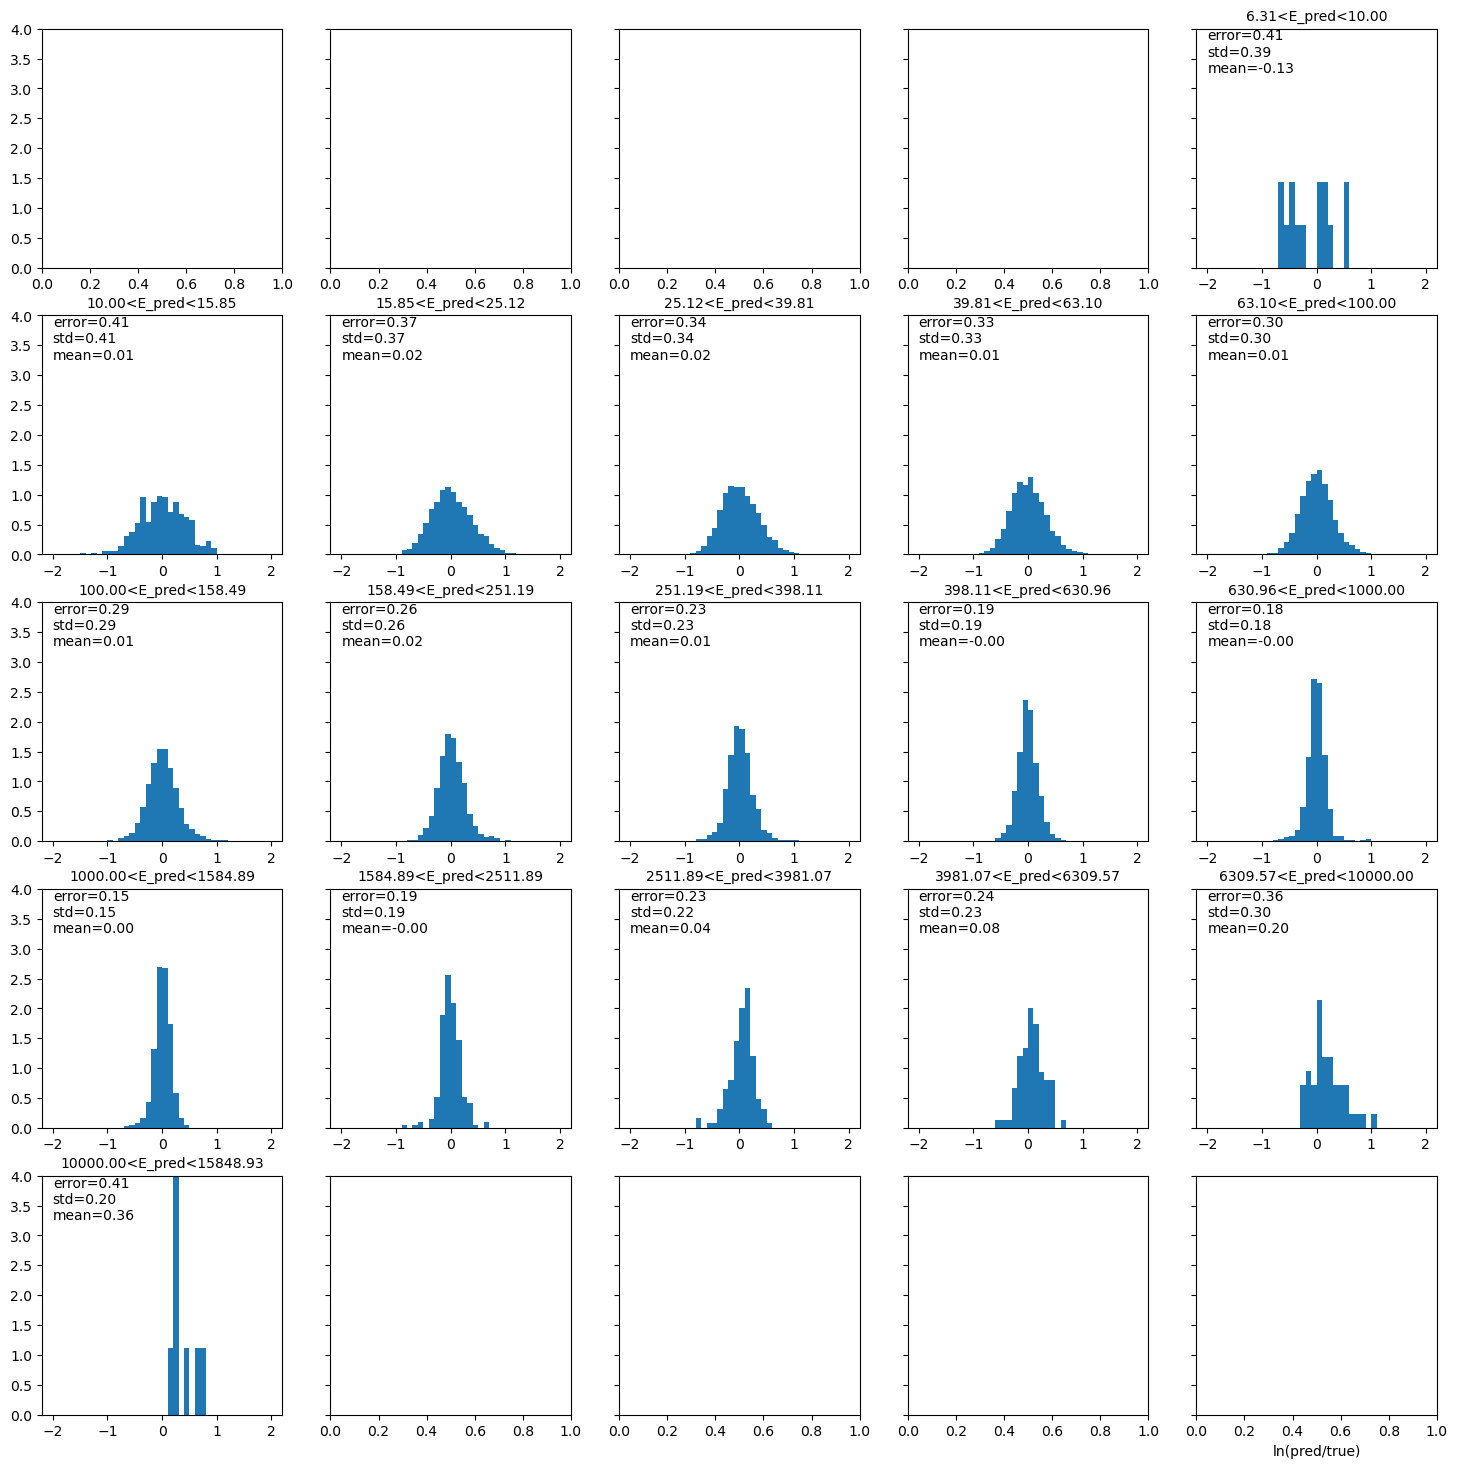

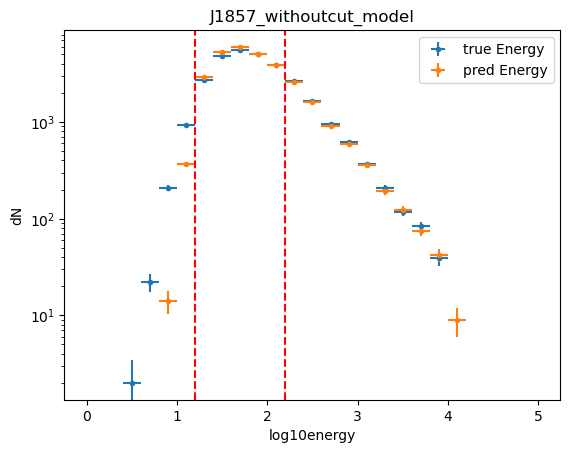

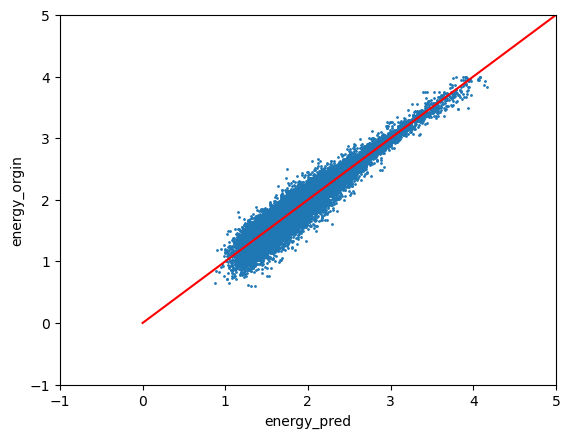

1.0 1.5848931924611136 nan
1.5848931924611136 2.51188643150958 nan
2.51188643150958 3.981071705534973 -1.0
3.981071705534973 6.309573444801933 -1.0
6.309573444801933 10.0 -0.9326923076923077
10.0 15.848931924611142 -0.6117021276595744
15.848931924611142 25.11886431509581 0.06632466104800293
25.11886431509581 39.810717055349734 0.10115846090194457
39.810717055349734 63.09573444801933 0.0659678293873125
63.09573444801933 100.0 0.002776125322228832
100.0 158.48931924611142 -0.015521628498727735
158.48931924611142 251.18864315095823 -0.026445032111824706
251.18864315095823 398.1071705534973 -0.020195838433292534
398.1071705534973 630.9573444801937 -0.049266247379454925
630.9573444801937 1000.0 -0.054838709677419356
1000.0 1584.893192461114 -0.010899182561307902
1584.893192461114 2511.886431509582 -0.08173076923076923
2511.886431509582 3981.0717055349733 0.05982905982905983
3981.0717055349733 6309.573444801937 -0.10714285714285714
6309.573444801937 10000.0 0.07692307692307693
10000.0 15848.

/tmp/ipykernel_46304/2156304196.py:90: RuntimeWarning: invalid value encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])
/tmp/ipykernel_46304/2156304196.py:90: RuntimeWarning: divide by zero encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])


In [9]:
energy_orgin = J1857_autogluon["prie"].to_numpy()/1000
predictor=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy")

energy_pred= 10**predictor.predict(J1857_autogluon).to_numpy()
check_fit(energy_pred, energy_orgin, f"J1857_withoutcut_model", f"/home2/hky/github/Gamma_Energy/AllSky/J1857_test/medium_quality_J1857test_withoutcut")

In [10]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.285819       5.373893  3322.030917                0.000851           0.762633            2       True         12
1         LightGBMLarge  -0.286199       1.055776   456.742354                1.055776         456.742354            1       True         11
2              LightGBM  -0.286385       1.345608   370.284058                1.345608         370.284058            1       True          4
3               XGBoost  -0.287122       0.967946    69.990813                0.967946          69.990813            1       True          9
4              CatBoost  -0.287168       0.036800    93.627356                0.036800          93.627356            1       True          6
5            LightGBMXT  -0.287314       1.728104   414.887696                1.728104      

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -0.3734246491683104,
  'KNeighborsDist': -0.3732741516028726,
  'LightGBMXT': -0.2873135093122218,
  'LightGBM': -0.2863854791502552,
  'RandomForestMSE': -0.2952302331898729,
  'CatBoost': -0.2871681259715463,
  'ExtraTreesMSE': -0.2971783262130827,
  'NeuralNetFastAI': -0.292377652166477,
  'XGBoost': -0.2871222490688364,
  'NeuralNetTorch': -0.30099376751153106,
  'LightGBMLarge': -0.28619942925274294,
  'WeightedEnsemble_L2': -0.2858193542260321},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif'

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

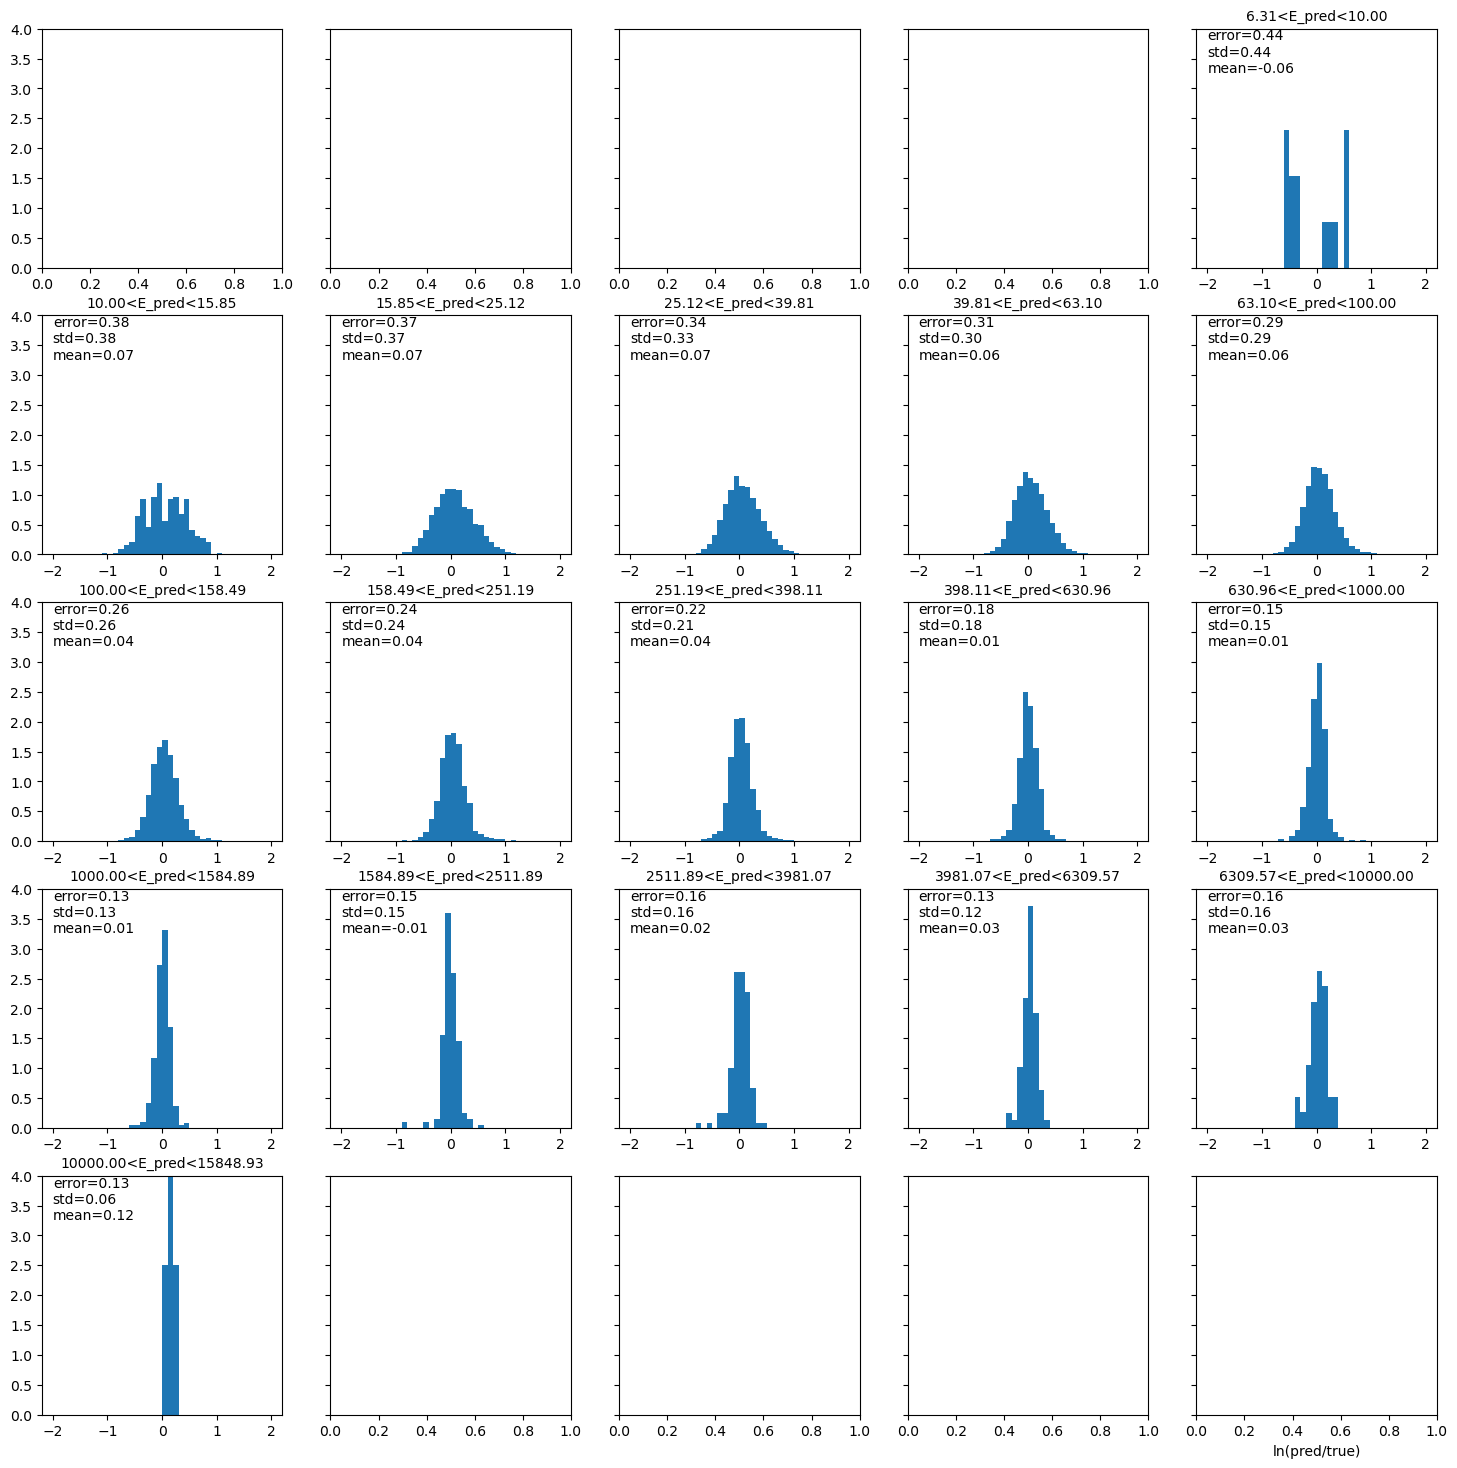

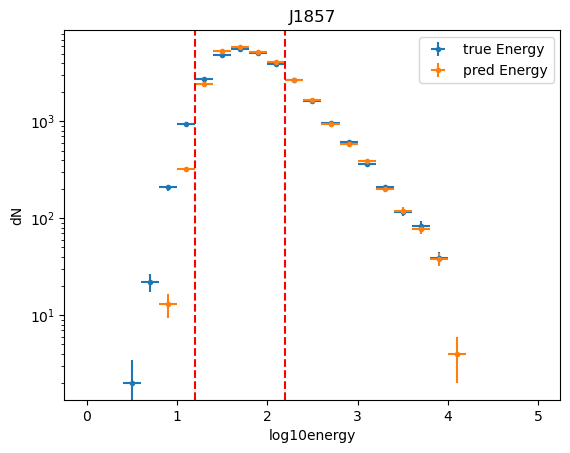

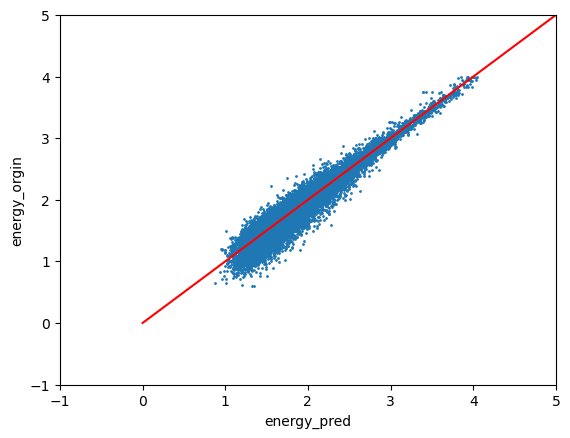

1.0 1.5848931924611136 nan
1.5848931924611136 2.51188643150958 nan
2.51188643150958 3.981071705534973 -1.0
3.981071705534973 6.309573444801933 -1.0
6.309573444801933 10.0 -0.9375
10.0 15.848931924611142 -0.6553191489361702
15.848931924611142 25.11886431509581 -0.1018688164162697
25.11886431509581 39.810717055349734 0.09164253206454283
39.810717055349734 63.09573444801933 0.04717151635640701
63.09573444801933 100.0 0.03351179853261947
100.0 158.48931924611142 0.05547073791348601
158.48931924611142 251.18864315095823 0.015489233094068758
251.18864315095823 398.1071705534973 0.00795593635250918
398.1071705534973 630.9573444801937 -0.011530398322851153
630.9573444801937 1000.0 -0.05
1000.0 1584.893192461114 0.051771117166212535
1584.893192461114 2511.886431509582 -0.038461538461538464
2511.886431509582 3981.0717055349733 0.017094017094017096
3981.0717055349733 6309.573444801937 -0.07142857142857142
6309.573444801937 10000.0 -0.02564102564102564
10000.0 15848.93192461114 inf
15848.931924611

/tmp/ipykernel_45922/2156304196.py:90: RuntimeWarning: invalid value encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])
/tmp/ipykernel_45922/2156304196.py:90: RuntimeWarning: divide by zero encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])


In [20]:
energy_orgin = J1857_autogluon["prie"].to_numpy()/1000
predictor=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=1/log10Energy")

energy_pred= 10**predictor.predict(J1857_autogluon).to_numpy()
check_fit(energy_pred, energy_orgin, f"J1857", f"/home2/hky/github/Gamma_Energy/AllSky/J1857_test/medium_quality_J1857test_withneage")

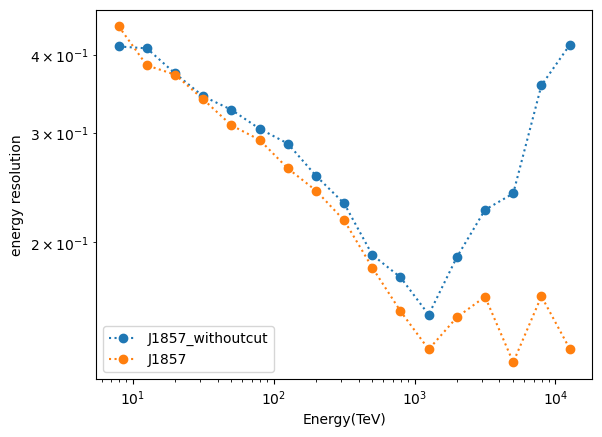

In [21]:
draw_precision()

In [158]:
cuted_J1857_2 = np.where( (data_J1857["inout"] == 1)&(data_J1857["sigma"] < 1)&(data_J1857["sumpf"] > 10**1.8)&(data_J1857["nch"] > 10))
data_test_J1857 = {key:data_J1857[key][cuted_J1857_2] for key in data_J1857.keys()}
pd_data_J1857 = pd.DataFrame(data_test_J1857)
pd_data_J1857[["sumpf"]]=np.log10(pd_data_J1857[["sumpf"]])

J1857_autogluon = TabularDataset(pd_data_J1857)

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

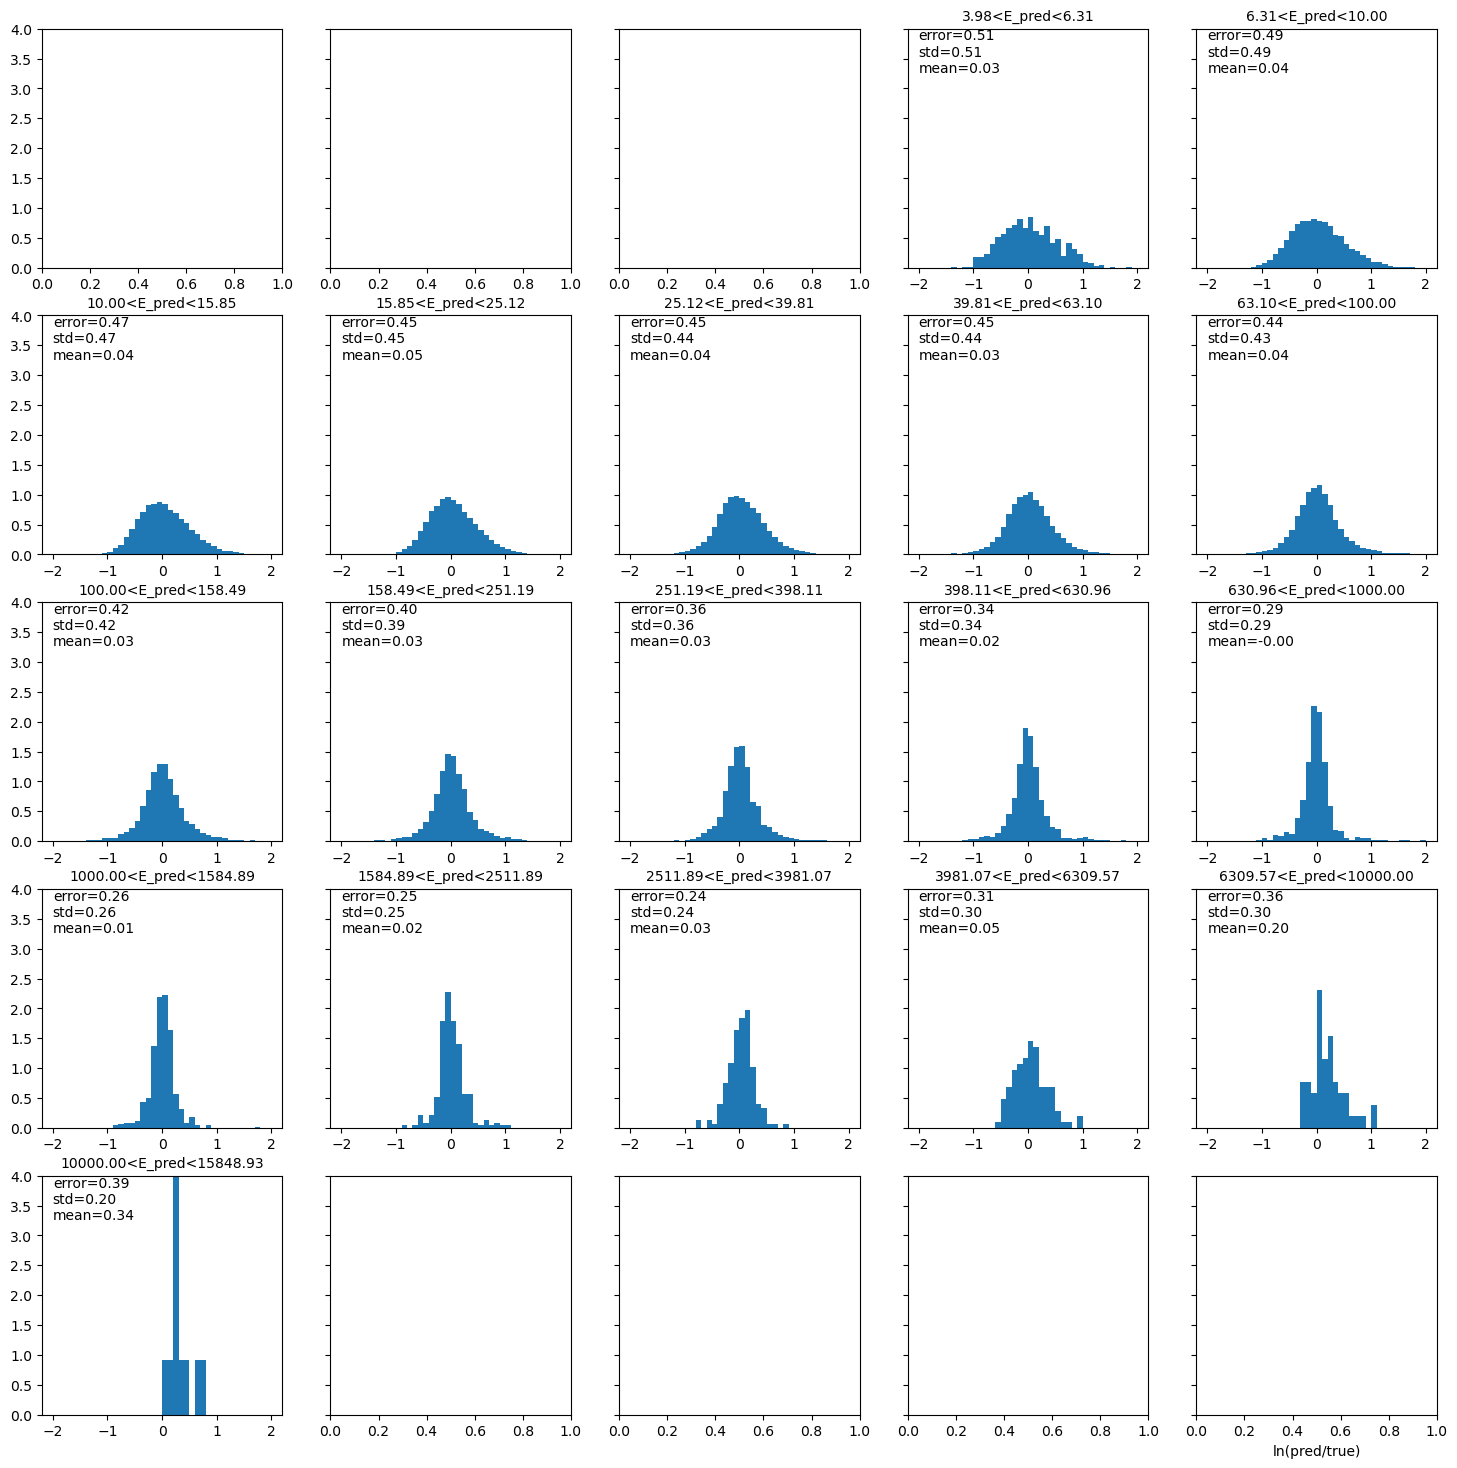

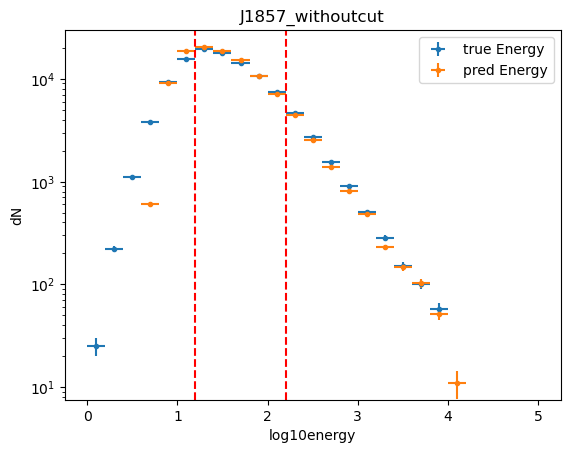

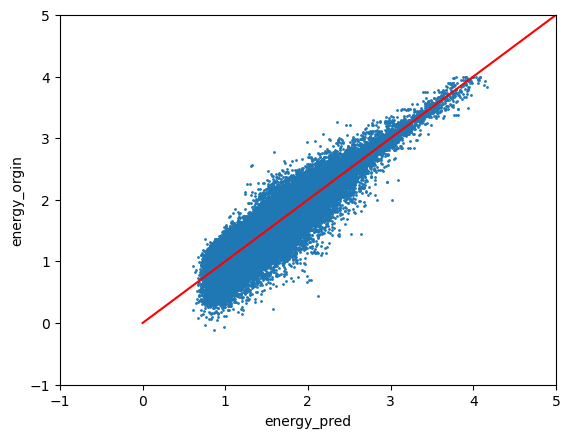

1.0 1.5848931924611136 -1.0
1.5848931924611136 2.51188643150958 -1.0
2.51188643150958 3.981071705534973 -1.0
3.981071705534973 6.309573444801933 -0.8403272631301135
6.309573444801933 10.0 -0.021689867270961477
10.0 15.848931924611142 0.19105795062044262
15.848931924611142 25.11886431509581 0.050796450993618014
25.11886431509581 39.810717055349734 0.05503400978132554
39.810717055349734 63.09573444801933 0.06829028635597979
63.09573444801933 100.0 0.004612632966205403
100.0 158.48931924611142 -0.06019754404698345
158.48931924611142 251.18864315095823 -0.05348391220967398
251.18864315095823 398.1071705534973 -0.06881405563689605
398.1071705534973 630.9573444801937 -0.11175710594315245
630.9573444801937 1000.0 -0.10927152317880795
1000.0 1584.893192461114 -0.04356435643564356
1584.893192461114 2511.886431509582 -0.1879432624113475
2511.886431509582 3981.0717055349733 -0.026490066225165563
3981.0717055349733 6309.573444801937 0.019801980198019802
6309.573444801937 10000.0 -0.103448275862068

/tmp/ipykernel_39559/2156304196.py:90: RuntimeWarning: divide by zero encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])
/tmp/ipykernel_39559/2156304196.py:90: RuntimeWarning: invalid value encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])


In [159]:
energy_orgin = J1857_autogluon["prie"].to_numpy()/1000
predictor=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy")

energy_pred= 10**predictor.predict(J1857_autogluon).to_numpy()
check_fit(energy_pred, energy_orgin, f"J1857_withoutcut", f"/home2/hky/github/Gamma_Energy/AllSky/J1857_test/medium_quality_J1857test_withoutcut_ALLevent")


In [160]:
predictor_theta=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/deltatheta")
predictor_phi=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/deltaphi")
dtheta = predictor_theta.predict(J1857_autogluon).to_numpy()
dphi = predictor_phi.predict(J1857_autogluon).to_numpy()
dtheta[np.abs(dtheta)>10]=0
dphi[np.abs(dphi)>10]=0
newtheta = J1857_autogluon["theta"].to_numpy()-dtheta
newphi = J1857_autogluon["phi"].to_numpy()-dphi

In [161]:
deltaangle = twoPointAngle(
    J1857_autogluon["theta"].to_numpy(), J1857_autogluon["pritheta"].to_numpy(), J1857_autogluon["phi"].to_numpy(), J1857_autogluon["priphi"].to_numpy())
newdeltaangle = twoPointAngle(
    newtheta, J1857_autogluon["pritheta"].to_numpy(), newphi, J1857_autogluon["priphi"].to_numpy())


0.7477566151847511 0.6791278579159398


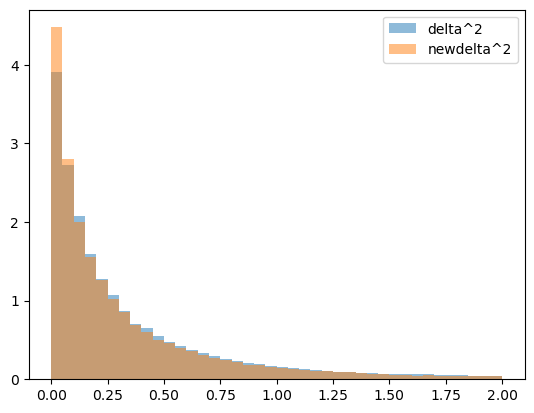

In [162]:
bins=np.linspace(0,2,41)
plt.hist(deltaangle**2,bins=bins,alpha=0.5,label="delta^2",density=True)
plt.hist(newdeltaangle**2,bins=bins,alpha=0.5,label="newdelta^2",density=True)
print(np.sqrt(np.mean(deltaangle**2)),np.sqrt(np.mean(newdeltaangle**2)))
# x=np.linspace(0,1,201)
# sigma_PSF=np.sqrt(np.mean(deltaangle**2))
# y=1/(2*np.pi*sigma_PSF**2)*np.exp(-x/sigma_PSF**2/2)
# plt.plot(x,y)
plt.legend()

In [163]:
parameter_list = ["nch", "theta", "phi", "sigma", "cx", "cy", "cr", "sumpf",
                  "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie"]
for para in parameter_list:
    datalist = [J1857_autogluon[para].to_numpy()[np.where((np.abs(deltaangle**2) < 0.5) & (energy_orgin < 25))],
                J1857_autogluon[para].to_numpy()[np.where((np.abs(deltaangle**2) > 0.5) & (energy_orgin < 25))]]
    legendlist = ["normal", "bad"]
    for binsnumber in [10, 20, 30, 40]:
        for if_logx in [0, 1]:
            for if_logy in [0, 1]:
                draw_compare_multiply(datalist, legendlist, paraname=para,
                                      bins_number=binsnumber, if_logx=if_logx, if_logy=if_logy, savepath=f"/home2/hky/github/Gamma_Energy/AllSky/J1857_test/checkbadangle/lowEnergy/{para}", savename=f"{para}_{binsnumber}_{if_logx}_{if_logy}.png")


nch_10_0_0.png
nch_10_0_1.png
nch_10_1_0.png
nch_10_1_1.png
nch_20_0_0.png
nch_20_0_1.png
nch_20_1_0.png
nch_20_1_1.png


/home2/hky/github/Gamma_Energy/AllSky/draw_compare_multiply.py:85: RuntimeWarning: invalid value encountered in divide
  counts_data / np.sum(counts_data) /
/home2/hky/github/Gamma_Energy/AllSky/draw_compare_multiply.py:87: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(counts_data)


nch_30_0_0.png
nch_30_0_1.png
nch_30_1_0.png
nch_30_1_1.png
nch_40_0_0.png
nch_40_0_1.png
nch_40_1_0.png
nch_40_1_1.png


/home2/hky/github/Gamma_Energy/AllSky/draw_compare_multiply.py:85: RuntimeWarning: divide by zero encountered in divide
  counts_data / np.sum(counts_data) /
/home2/hky/github/Gamma_Energy/AllSky/draw_compare_multiply.py:87: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(counts_data)
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


theta_10_0_0.png
theta_10_0_1.png
theta_10_1_0.png
theta_10_1_1.png
theta_20_0_0.png
theta_20_0_1.png
theta_20_1_0.png
theta_20_1_1.png
theta_30_0_0.png
theta_30_0_1.png
theta_30_1_0.png
theta_30_1_1.png
theta_40_0_0.png
theta_40_0_1.png
theta_40_1_0.png
theta_40_1_1.png
phi_10_0_0.png
phi_10_0_1.png
phi_20_0_0.png
phi_20_0_1.png
phi_30_0_0.png
phi_30_0_1.png
phi_40_0_0.png
phi_40_0_1.png
sigma_10_0_0.png
sigma_10_0_1.png
sigma_10_1_0.png
sigma_10_1_1.png
sigma_20_0_0.png
sigma_20_0_1.png
sigma_20_1_0.png
sigma_20_1_1.png
sigma_30_0_0.png
sigma_30_0_1.png
sigma_30_1_0.png
sigma_30_1_1.png
sigma_40_0_0.png
sigma_40_0_1.png
sigma_40_1_0.png
sigma_40_1_1.png
cx_10_0_0.png
cx_10_0_1.png
cx_20_0_0.png
cx_20_0_1.png
cx_30_0_0.png
cx_30_0_1.png
cx_40_0_0.png
cx_40_0_1.png
cy_10_0_0.png
cy_10_0_1.png
cy_20_0_0.png
cy_20_0_1.png
cy_30_0_0.png
cy_30_0_1.png
cy_40_0_0.png
cy_40_0_1.png
cr_10_0_0.png
cr_10_0_1.png
cr_10_1_0.png
cr_10_1_1.png
cr_20_0_0.png
cr_20_0_1.png
cr_20_1_0.png
cr_20_1_1.png


In [164]:
energy_orgin=J1857_autogluon["prie"].to_numpy()/1000

In [165]:
anglesigma = list()
anglesigma_new = list()

for i in range(len(Energy_bin)-1):
    tmp_cuted = np.where((energy_orgin>Energy_bin[i])&(energy_orgin<Energy_bin[i+1]))
    anglesigma.append(np.sqrt(np.mean(deltaangle[tmp_cuted]**2)))
    anglesigma_new.append(np.sqrt(np.mean(newdeltaangle[tmp_cuted]**2)))

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


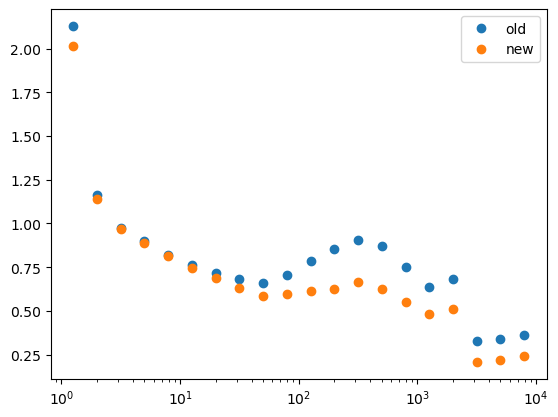

In [166]:
plt.plot(Energy_bin_center,anglesigma,"o",label="old")
plt.plot(Energy_bin_center,anglesigma_new,"o",label="new")
plt.xscale("log")
# plt.xlim(10,1000) 
plt.legend()

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


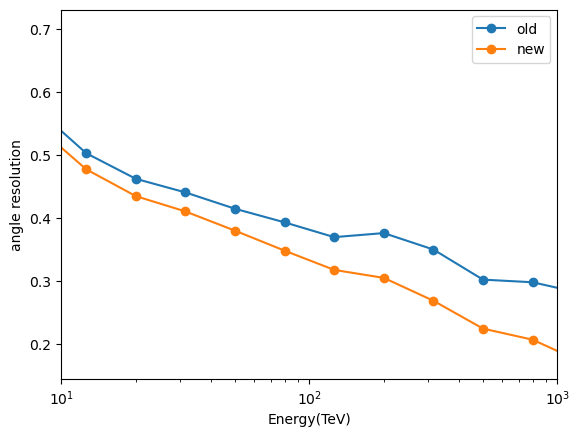

In [6]:

# cuted_J1857_3 = np.where( (data_J1857["inout"] == 1)&(data_J1857["sigma"] < 1)&(data_J1857["nch"] >= 16)&(data_J1857["age"]>0.31)&(data_J1857["age"]<1.3)&(data_J1857["ne"]>1e4))
cuted_J1857_3 = np.where((data_J1857["theta"] < 50) & (data_J1857["nch"] >= 16)
                 & (data_J1857["inout"] == 1) & (data_J1857['sigma'] < 1.)
                 & (data_J1857["age"] > 0.31) & (data_J1857['age'] < 1.3)
                 & (data_J1857["S50"] > 10**-1.2)
                 & (data_J1857['sumpf'] > 200)
                 & ((data_J1857["summd"] < 1.8e-5*data_J1857["sumpf"]**1.8) | (data_J1857["summd"] < 0.4)))
data_test_J1857 = {key:data_J1857[key][cuted_J1857_3] for key in data_J1857.keys()}
pd_data_J1857 = pd.DataFrame(data_test_J1857)
pd_data_J1857[["ne","sumpf"]]=np.log10(pd_data_J1857[["ne","sumpf"]])

J1857_autogluon = TabularDataset(pd_data_J1857)
energy_orgin = J1857_autogluon["prie"].to_numpy()/1000
predictor=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=1/log10Energy")

# energy_pred= 10**predictor.predict(J1857_autogluon).to_numpy()
# check_fit(energy_pred, energy_orgin, f"J1857_withoutcut", f"/home2/hky/github/Gamma_Energy/AllSky/J1857_test/medium_quality_J1857test_withoutcut_ALLevent")

predictor_theta=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/deltatheta")
predictor_phi=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/deltaphi")
dtheta = predictor_theta.predict(J1857_autogluon).to_numpy()
dphi = predictor_phi.predict(J1857_autogluon).to_numpy()
dtheta[np.abs(dtheta)>10]=0
dphi[np.abs(dphi)>10]=0
newtheta = J1857_autogluon["theta"].to_numpy()-dtheta
newphi = J1857_autogluon["phi"].to_numpy()-dphi
deltaangle = twoPointAngle(
    J1857_autogluon["theta"].to_numpy(), J1857_autogluon["pritheta"].to_numpy(), J1857_autogluon["phi"].to_numpy(), J1857_autogluon["priphi"].to_numpy())
newdeltaangle = twoPointAngle(
    newtheta, J1857_autogluon["pritheta"].to_numpy(), newphi, J1857_autogluon["priphi"].to_numpy())

# bins=np.linspace(0,2,41)
# plt.hist(deltaangle**2,bins=bins,alpha=0.5,label="delta^2",density=True)
# plt.hist(newdeltaangle**2,bins=bins,alpha=0.5,label="newdelta^2",density=True)
# print(np.sqrt(np.mean(deltaangle**2)),np.sqrt(np.mean(newdeltaangle**2)))
# plt.legend()
# plt.show()

# parameter_list = ["nch", "theta", "phi", "sigma", "cx", "cy", "cr", "sumpf",
#                   "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie"]
# for para in parameter_list:
#     datalist = [J1857_autogluon[para].to_numpy()[np.where((np.abs(deltaangle**2) < 0.3))],
#                 J1857_autogluon[para].to_numpy()[np.where((np.abs(deltaangle**2) > 0.3))]]
#     legendlist = ["normal", "bad"]
#     for binsnumber in [10, 20, 30, 40]:
#         for if_logx in [0, 1]:
#             for if_logy in [0, 1]:
#                 draw_compare_multiply(datalist, legendlist, paraname=para,
#                                       bins_number=binsnumber, if_logx=if_logx, if_logy=if_logy, savepath=f"/home2/hky/github/Gamma_Energy/AllSky/J1857_test/checkbadangle/highEnergy/{para}", savename=f"{para}_{binsnumber}_{if_logx}_{if_logy}.png")

energy_orgin=J1857_autogluon["prie"].to_numpy()/1000
anglesigma = list()
anglesigma_new = list()

for i in range(len(Energy_bin)-1):
    tmp_cuted = np.where((energy_orgin>Energy_bin[i])&(energy_orgin<Energy_bin[i+1]))
    anglesigma.append(np.sqrt(np.mean(deltaangle[tmp_cuted]**2)))
    anglesigma_new.append(np.sqrt(np.mean(newdeltaangle[tmp_cuted]**2)))
plt.plot(Energy_bin_center,anglesigma,"o-",label="old")
plt.plot(Energy_bin_center,anglesigma_new,"o-",label="new")
plt.xscale("log")
plt.xlim(10,1000) 
plt.xlabel("Energy(TeV)")
plt.ylabel("angle resolution")
plt.legend()
plt.show()